# Beta Convergence Analysis

Test whether the data is consistent with the theory of beta convergence. Treat $\mathbf{z}_i$ as high-dim.
$$
g_i = \beta y_{i0} + \mathbf{z}_i'\gamma + u_i
$$
$y_{i0}$ is the initial log GDP per capita. The controls are $\mathbf{z}_i$ and $u_i$ is an idiosyncratic error term.

## Analysis Workflow
1. **Data Preparation**: Load and clean data, create polynomial features
2. **Model Estimation**: Run OLS, PSL, PDL, PPOL and PDS for both original and polynomial controls
3. **Results**: Generate results table with confidence intervals
4. **Variable Selection**: Show list of variable selections for each candidate set, for each method and penalty, for each stage when relevant.
4. **Visualization**: Plot first and second stage Lasso paths for selected models

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functions_lasso_refactored import *

%load_ext autoreload
%autoreload 2

## 1. Data Loading and Variable Definitions

In [2]:
# Read data
dat = pd.read_csv('growth.csv')
lbldf = pd.read_csv('labels.csv', index_col='variable')
lbl_all = lbldf.label.to_dict()

print(f"Dataset shape: {dat.shape}")
print(f"Available variables: {dat.shape[1]}")

Dataset shape: (214, 85)
Available variables: 85


In [3]:
# Variable definitions by category
vv_institutions = ['marketref', 'dem', 'demCGV', 'demBMR', 'demreg'] 
vv_geography = [
    'tropicar','distr', 'distcr', 'distc','suitavg','temp', 'suitgini', 'elevavg', 'elevstd',
    'kgatr', 'precip', 'area', 'abslat', 'cenlong', 'area_ar', 'rough','landlock', 
    'africa', 'asia', 'oceania', 'americas'
]
vv_geneticdiversity = ['pdiv', 'pdiv_aa', 'pdivhmi', 'pdivhmi_aa']
vv_historical = ['pd1000', 'pd1500', 'pop1000', 'pop1500', 'ln_yst']
vv_religion = ['pprotest', 'pcatholic', 'pmuslim']
vv_danger = ['yellow', 'malfal', 'uvdamage']
vv_resources = ['oilres', 'goldm', 'iron', 'silv', 'zinc']
vv_educ = ['ls_bl', 'lh_bl']

# Control variable groups
zs_common_control = ['pop_growth', 'investment_rate']
zs_uncommon_control = (vv_geography + vv_resources + vv_danger + vv_religion + ['dem'] + ['demCGV'] + ['demBMR'] + ['demreg'] + ['pop1500'] + ["pd1500"] + ['pdiv'] + ["ln_yst"])
#zs_uncommon_control = (vv_resources+["asia"]+["pop1500"] + ["demCGV"] + vv_religion)

dummy_vars = ['dem', 'demCGV', 'demBMR']

print(f"Common controls: {len(zs_common_control)}")
print(f"Uncommon controls: {len(zs_uncommon_control)}")
print(f"Total controls (Z) without polynomial features: {len(zs_common_control + zs_uncommon_control)}")

Common controls: 2
Uncommon controls: 40
Total controls (Z) without polynomial features: 42


## 2. Complete Analysis (Current Variable Set)

Run the entire analysis for both original controls (37 variables) and polynomial-expanded controls using a single function call.

In [13]:
# Run complete analysis for both control sets
results, dat_processed = run_complete_analysis(
    dat=dat,
    zs_common_control=zs_common_control,
    zs_uncommon_control=zs_uncommon_control,
    dummy_vars=dummy_vars,
    penalty_types=['CV', 'BRT', 'BCCH'],
    rounding_digits=4
)

Preparing data...
Z shape: (88, 42)
Z poly shape: (88, 603)

Analyzing original controls...
Computed BRT penalty: 0.5044
Computed BCCH penalty: 1.6971

RESULTS SUMMARY - ORIGINAL CONTROLS

OLS ESTIMATES:
Method                    Estimate        SE         CI Lower     CI Upper    
--------------------------------------------------------------------------------
No Controls               -0.1209         0.2436     -0.5984      0.3566      
With Controls             -1.8102         0.2125     -2.2266      -1.3937     
With Poly                 -354.7671       0.2321     -355.2220    -354.3121   

PSL ESTIMATES:
Penalty    Estimate        SE         CI Lower     CI Upper    
-----------------------------------------------------------------
CV         0.0329          0.0813     -0.1264      0.1922      
BRT        -0.3241         0.1098     -0.5393      -0.1088     
BCCH       -0.1209         0.1519     -0.4186      0.1767      

PDL ESTIMATES:
Penalty    Estimate        SE         CI Lowe

In [5]:
# # Comprehensive variable availability assessment
# def assess_variable_availability(dat, current_vars, target_vars=['gdp_growth', 'lgdp_initial'], 
#                                 min_sample_size=80, dummy_vars_to_fill=['dem', 'demCGV', 'demBMR'],
#                                 exclude_vars=['code']):  # Exclude country index and other irrelevant vars
#     """
#     Assess which variables can be added without reducing sample size below threshold
#     """
#     print("="*80)
#     print("VARIABLE AVAILABILITY ASSESSMENT")
#     print("="*80)
    
#     # Clean dummy variables
#     dat_clean = dat.copy()
#     for var in dummy_vars_to_fill:
#         if var in dat_clean.columns:
#             dat_clean[var] = dat_clean[var].fillna(0)
    
#     # Baseline sample (only target variables)
#     baseline_mask = dat_clean[target_vars].notnull().all(axis=1)
#     baseline_n = baseline_mask.sum()
#     print(f"\nBaseline sample (only {target_vars}): {baseline_n} countries")
    
#     # Current variable set sample size
#     current_available_vars = [var for var in current_vars if var in dat_clean.columns]
#     current_mask = dat_clean[target_vars + current_available_vars].notnull().all(axis=1)
#     current_n = current_mask.sum()
#     print(f"Current variable set: {current_n} countries")
#     print(f"Variables in current set: {len(current_available_vars)}")
    
#     # Analyze all other variables (exclude irrelevant ones)
#     all_vars = dat_clean.columns.tolist()
#     candidate_vars = [var for var in all_vars 
#                      if var not in target_vars + current_available_vars + exclude_vars]
    
#     print(f"\nAnalyzing {len(candidate_vars)} candidate variables...")
#     print(f"(Excluding: {exclude_vars})")
    
#     # Check each variable individually
#     var_analysis = []
    
#     for var in candidate_vars:
#         # Test adding this variable to current set
#         test_vars = target_vars + current_available_vars + [var]
#         test_mask = dat_clean[test_vars].notnull().all(axis=1)
#         test_n = test_mask.sum()
        
#         # Check if variable is binary
#         non_null_values = dat_clean[var].dropna()
#         is_binary = len(non_null_values) > 0 and set(non_null_values.unique()).issubset({0, 1, 0.0, 1.0})
        
#         # Count missing values in the baseline sample
#         baseline_subset = dat_clean[baseline_mask]
#         missing_in_baseline = baseline_subset[var].isnull().sum()
#         missing_pct_baseline = (missing_in_baseline / baseline_n) * 100
        
#         # Total missing in full dataset
#         total_missing = dat_clean[var].isnull().sum()
#         total_missing_pct = (total_missing / len(dat_clean)) * 100
        
#         var_analysis.append({
#             'variable': var,
#             'sample_size_if_added': test_n,
#             'countries_lost': current_n - test_n,
#             'is_binary': is_binary,
#             'missing_in_baseline': missing_in_baseline,
#             'missing_pct_baseline': missing_pct_baseline,
#             'total_missing': total_missing,
#             'total_missing_pct': total_missing_pct,
#             'feasible': test_n >= min_sample_size
#         })
    
#     # Convert to DataFrame for easier analysis
#     var_df = pd.DataFrame(var_analysis)
    
#     # Summary statistics
#     feasible_vars = var_df[var_df['feasible']].copy()
#     binary_vars = var_df[var_df['is_binary']].copy()
    
#     print(f"\n" + "="*60)
#     print("SUMMARY STATISTICS")
#     print("="*60)
#     print(f"Total variables analyzed: {len(candidate_vars)}")
#     print(f"Variables that maintain N≥{min_sample_size}: {len(feasible_vars)}")
#     print(f"Binary variables: {len(binary_vars)}")
#     print(f"Binary variables that are feasible: {len(binary_vars[binary_vars['feasible']])}")
    
#     # Show feasible variables
#     if len(feasible_vars) > 0:
#         print(f"\n" + "="*60)
#         print(f"FEASIBLE VARIABLES (maintain N≥{min_sample_size})")
#         print("="*60)
#         print("Format: Variable | Final N | Countries Lost | Missing in Baseline | Total Missing")
#         print("-" * 80)
#         feasible_sorted = feasible_vars.sort_values('countries_lost')
#         for _, row in feasible_sorted.iterrows():
#             binary_flag = " [BINARY]" if row['is_binary'] else ""
#             print(f"{row['variable']:<20} | N={row['sample_size_if_added']:>3} | lose {row['countries_lost']:>2} | "
#                   f"{row['missing_pct_baseline']:>4.1f}% baseline | {row['total_missing_pct']:>4.1f}% total{binary_flag}")
    
#     # Identify dummy trap issues
#     geography_dummies = ['africa', 'europe', 'asia', 'oceania', 'americas']
#     current_geo_dummies = [var for var in current_available_vars if var in geography_dummies]
#     feasible_geo_dummies = [var for var in feasible_vars['variable'] if var in geography_dummies]
    
#     if feasible_geo_dummies:
#         print(f"\n" + "="*60)
#         print("POTENTIAL DUMMY TRAP WARNING")
#         print("="*60)
#         print(f"Current geography dummies in model: {current_geo_dummies}")
#         print(f"Additional geography dummies found feasible: {feasible_geo_dummies}")
#         print("⚠️  Including all geography dummies will create perfect multicollinearity!")
#         print("   Consider excluding one as reference category (typically 'europe')")
    
#     # Show variables with moderate missing data that could be interpolated
#     print(f"\n" + "="*60)
#     print("VARIABLES WITH MODERATE MISSING DATA (could interpolate)")
#     print("="*60)
#     moderate_missing = var_df[(var_df['missing_pct_baseline'] >= 5) & 
#                              (var_df['missing_pct_baseline'] <= 30)].copy()
#     moderate_missing = moderate_missing.sort_values('missing_pct_baseline')
    
#     for _, row in moderate_missing.iterrows():
#         binary_flag = " [BINARY]" if row['is_binary'] else ""
#         feasible_flag = " ✓" if row['feasible'] else " ✗"
#         print(f"{row['variable']:<20} | N={row['sample_size_if_added']:>3} | "
#               f"{row['missing_pct_baseline']:>4.1f}% missing in baseline{binary_flag}{feasible_flag}")
    
#     return var_df, feasible_vars

# # Run the improved assessment  
# var_analysis_df, feasible_additions = assess_variable_availability(
#     dat=dat,
#     current_vars=zs_common_control + zs_uncommon_control,
#     target_vars=['gdp_growth', 'lgdp_initial'],
#     min_sample_size=80,
#     exclude_vars=['code']  # Exclude country index
# )

In [6]:
# # Create optimal expanded variable set
# def create_optimal_variable_set(feasible_vars, current_vars, max_sample_loss=8):
#     """
#     Create an optimal expanded variable set by adding feasible variables
#     """
#     print("\n" + "="*60)
#     print("CREATING OPTIMAL EXPANDED VARIABLE SET")
#     print("="*60)
    
#     # Get the best feasible variables (lose fewest countries)
#     best_additions = feasible_vars[feasible_vars['countries_lost'] <= max_sample_loss].copy()
#     best_additions = best_additions.sort_values('countries_lost')
    
#     # Handle dummy trap: exclude 'europe' if it's in the feasible set
#     geography_dummies = ['africa', 'europe', 'asia', 'oceania', 'americas']
#     dummy_trap_exclusions = []
    
#     if 'europe' in best_additions['variable'].values:
#         dummy_trap_exclusions.append('europe')
#         print(f"⚠️  Excluding 'europe' to avoid dummy trap (using as reference category)")
    
#     # Filter out dummy trap variables
#     best_additions_clean = best_additions[~best_additions['variable'].isin(dummy_trap_exclusions)]
    
#     print(f"\nVariables that lose ≤{max_sample_loss} countries:")
#     print("-" * 50)
    
#     recommended_additions = []
#     for _, row in best_additions_clean.iterrows():
#         binary_flag = " [BINARY]" if row['is_binary'] else ""
#         print(f"✓ {row['variable']:<20} (lose {row['countries_lost']}) {binary_flag}")
#         recommended_additions.append(row['variable'])
    
#     if dummy_trap_exclusions:
#         print(f"\nExcluded to avoid dummy trap:")
#         for var in dummy_trap_exclusions:
#             print(f"✗ {var:<20} (would cause perfect multicollinearity)")
    
#     # Create expanded variable sets
#     expanded_common = zs_common_control.copy()
#     expanded_uncommon = zs_uncommon_control + recommended_additions
    
#     print(f"\n" + "="*60)
#     print("PROPOSED EXPANDED VARIABLE SETS")
#     print("="*60)
#     print(f"Original uncommon controls: {len(zs_uncommon_control)}")
#     print(f"Recommended additions: {len(recommended_additions)}")
#     print(f"Expanded uncommon controls: {len(expanded_uncommon)}")
#     print(f"Total controls (common + uncommon): {len(expanded_common) + len(expanded_uncommon)}")
    
#     print(f"\nRecommended additions:")
#     for var in recommended_additions:
#         print(f"  - {var}")
    
#     # Check geography dummy coverage
#     current_geo = [var for var in expanded_common + expanded_uncommon if var in geography_dummies]
#     if current_geo:
#         print(f"\nGeography dummies in expanded set: {current_geo}")
#         missing_geo = [var for var in geography_dummies if var not in current_geo and var != 'europe']
#         if missing_geo:
#             print(f"Missing geography dummies: {missing_geo} (using 'europe' as reference)")
    
#     # Also suggest variables that could be interpolated
#     interpolation_candidates = feasible_vars[
#         (feasible_vars['countries_lost'] <= 15) & 
#         (feasible_vars['is_binary'] == True) &
#         (~feasible_vars['variable'].isin(dummy_trap_exclusions))
#     ].copy()
    
#     if len(interpolation_candidates) > 0:
#         print(f"\n" + "="*60)
#         print("BINARY VARIABLES FOR POTENTIAL INTERPOLATION")
#         print("="*60)
#         print("These binary variables could be filled with 0 (like democracy variables):")
#         for _, row in interpolation_candidates.iterrows():
#             print(f"  - {row['variable']} (would lose {row['countries_lost']} countries)")
    
#     return expanded_common, expanded_uncommon, recommended_additions

# # Create the optimal set
# expanded_common, expanded_uncommon, additions = create_optimal_variable_set(
#     feasible_additions, 
#     zs_common_control + zs_uncommon_control,
#     max_sample_loss=8
# )

# print(f"\n" + "="*60)
# print("INTERPRETATION GUIDE")
# print("="*60)
# print("📊 How to read the results:")
# print()
# print("✅ 'N=88 (lose 0)' means:")
# print("   - Final sample size would be 88 countries") 
# print("   - No countries lost compared to current 88-country sample")
# print("   - Variable has complete data for all countries in current sample")
# print()
# print("📈 'Missing % baseline' vs 'Missing % total':")
# print("   - Baseline: % missing among the 102 countries with gdp_growth & lgdp_initial")
# print("   - Total: % missing among all 214 countries in dataset")
# print()
# print("⚠️  Dummy trap warning:")
# print("   - 'europe' excluded automatically as reference category")
# print("   - Including all geography dummies would create perfect collinearity")
# print()
# print("🔧 IMPLEMENTATION CODE")
# print("="*60)
# print("# To use the expanded variable set:")
# print()
# print("# Expanded variable definitions")
# print(f"zs_common_control_expanded = {expanded_common}")
# print(f"zs_uncommon_control_expanded = {expanded_uncommon}")
# print()
# print("# Run analysis with expanded set:")
# print("# results_expanded, dat_processed_expanded = run_complete_analysis(")
# print("#     dat=dat,")
# print("#     zs_common_control=zs_common_control_expanded,")
# print("#     zs_uncommon_control=zs_uncommon_control_expanded,")
# print("#     dummy_vars=dummy_vars,")
# print("#     penalty_types=['CV', 'BRT', 'BCCH'],")
# print("#     rounding_digits=4")
# print("# )")

In [7]:
# # FINAL CHECK: Let's rerun the variable assessment with debug info
# print("\n" + "="*80)
# print("RERUNNING VARIABLE ASSESSMENT WITH DEBUG INFO")
# print("="*80)

# # Let's manually check a few variables step by step
# print(f"Total variables in dataset: {len(dat.columns)}")
# print(f"Current variable set: {zs_common_control + zs_uncommon_control}")
# print(f"Length of current set: {len(zs_common_control + zs_uncommon_control)}")

# # Count how many candidate variables we should have
# target_vars = ['gdp_growth', 'lgdp_initial']
# current_vars = zs_common_control + zs_uncommon_control
# exclude_vars = ['code']

# all_vars = dat.columns.tolist()
# candidate_vars = [var for var in all_vars 
#                  if var not in target_vars + current_vars + exclude_vars]

# print(f"\nAll variables in dataset: {len(all_vars)}")
# print(f"Target variables: {len(target_vars)} -> {target_vars}")
# print(f"Current variables: {len(current_vars)}")
# print(f"Exclude variables: {len(exclude_vars)} -> {exclude_vars}")
# print(f"Candidate variables: {len(candidate_vars)}")

# print(f"\nFirst 10 candidate variables: {candidate_vars[:10]}")
# print(f"Last 10 candidate variables: {candidate_vars[-10:]}")

# # Now let's check our variable assessment results
# if 'var_analysis_df' in locals():
#     print(f"\nVariable analysis DataFrame shape: {var_analysis_df.shape}")
#     if len(var_analysis_df) > 0:
#         print(f"Feasible variables: {len(var_analysis_df[var_analysis_df['feasible']])}")
#         print(f"Variables that lose 0 countries: {len(var_analysis_df[var_analysis_df['countries_lost'] == 0])}")
        
#         # Show some examples
#         zero_loss = var_analysis_df[var_analysis_df['countries_lost'] == 0]
#         if len(zero_loss) > 0:
#             print(f"\nVariables that lose 0 countries:")
#             for _, row in zero_loss.head(5).iterrows():
#                 print(f"  {row['variable']}: N={row['sample_size_if_added']}")
# else:
#     print("var_analysis_df not found - the assessment might not have run properly")

## Lasso Paths


LASSO PATHS - ORIGINAL CONTROLS


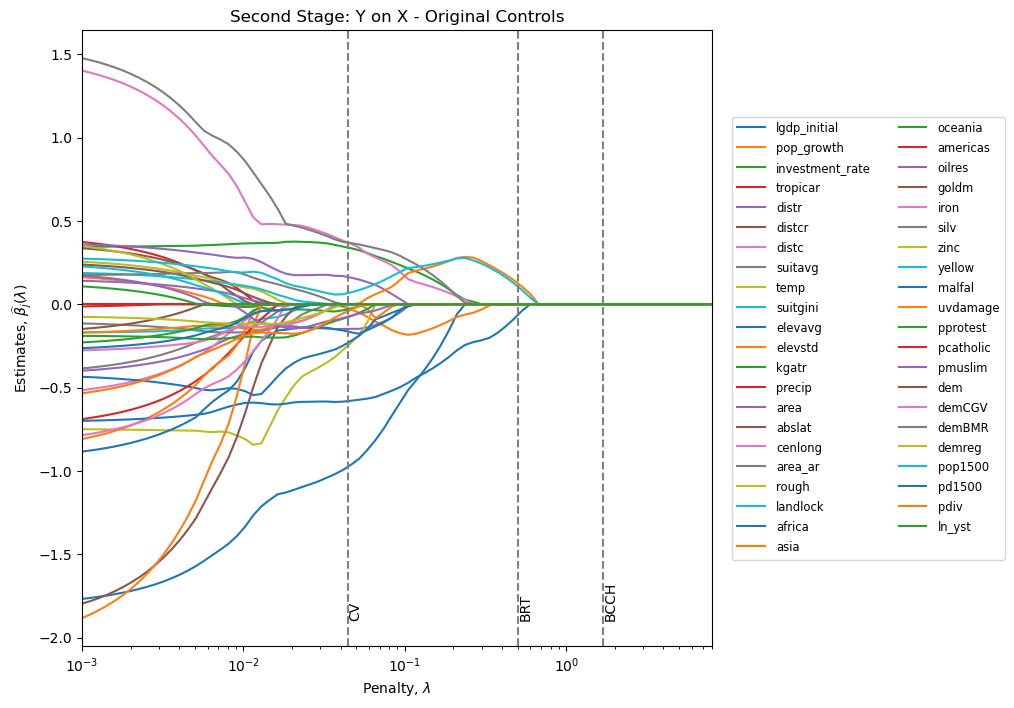

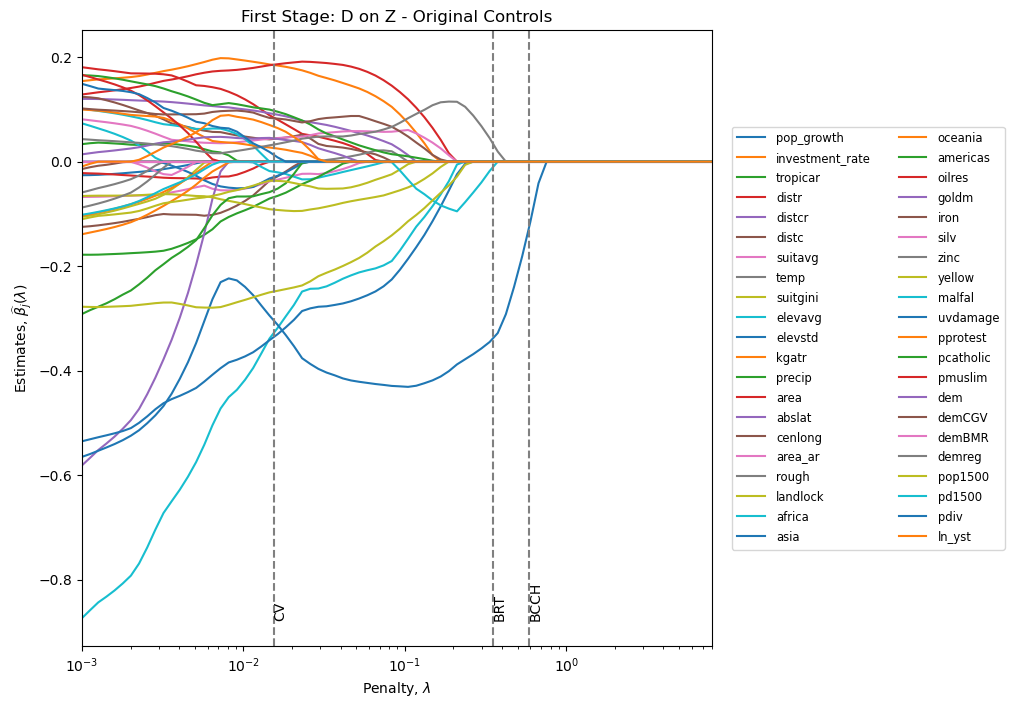


LASSO PATHS - POLY CONTROLS


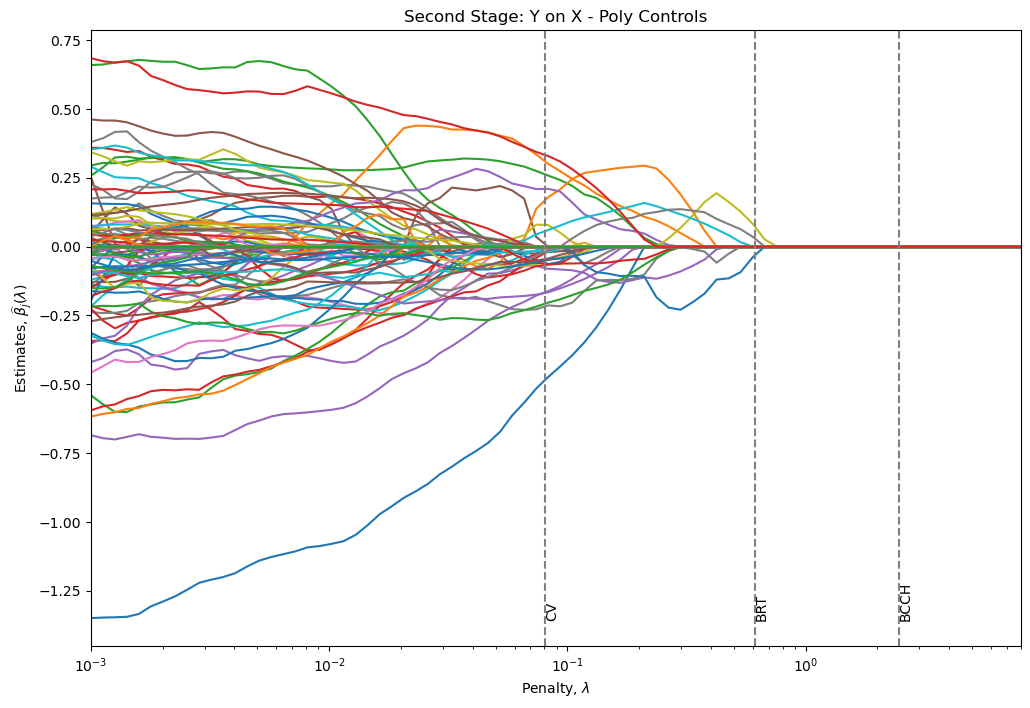

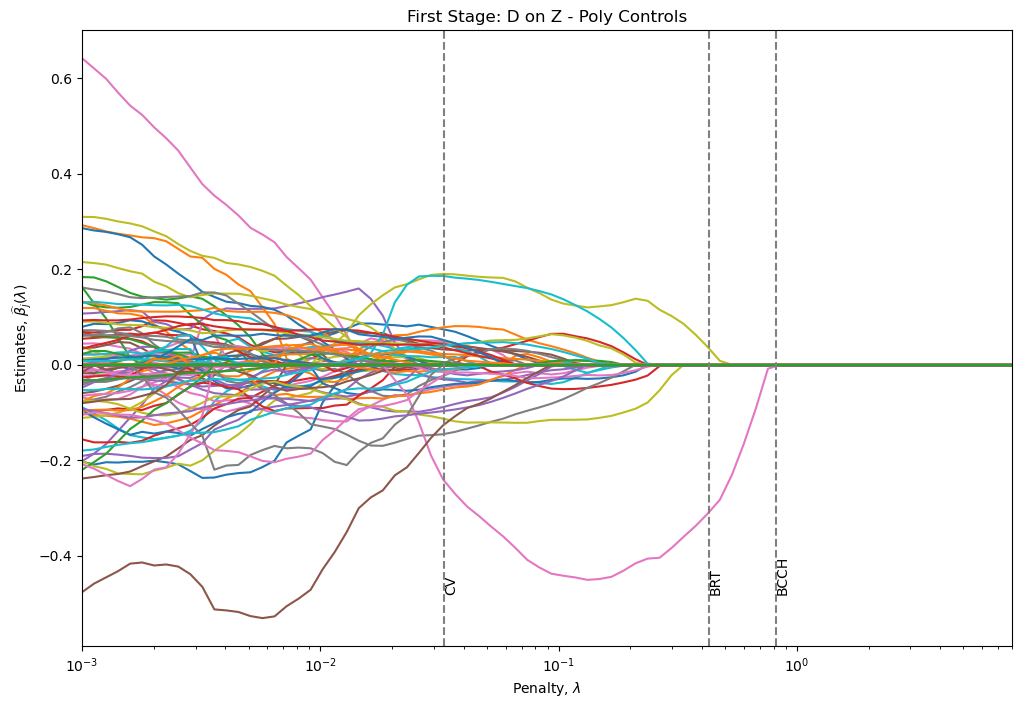

In [8]:
# Generate all Lasso paths for both control sets
generate_and_plot_all_lasso_paths(dat_processed)

## 6. Summary and Conclusions

Final summary of key findings and methodological insights.

In [9]:
print("\n" + "="*80)
print("ECONOMIC INTERPRETATION")
print("="*80)

print("\n1. BETA CONVERGENCE THEORY:")
print("   - Negative coefficient on initial GDP indicates convergence")
print("   - Magnitude indicates speed of convergence")
print("   - Statistical significance confirms convergence hypothesis")

print("\n2. METHODOLOGICAL COMPARISON:")
print("   - OLS without controls: Potential omitted variable bias")
print("   - OLS with controls: May suffer from overfitting in high-dimensional setting, or downright infeasible")
print("   - PSL: Single-step variable selection")
print("   - PDL: Two-stage selection (outcome and treatment)")
print("   - PPOL: Partialling out approach")
print("   - PDS: Double selection approach")

print("\n3. PENALTY SELECTION:")
print("   - CV: Data-driven cross-validation")
print("   - BRT: Theory-based penalty (Belloni, Rothe, Tamm)")
print("   - BCCH: Adaptive penalty (Belloni, Chernozhukov, Chen, Hansen)")

# Check for convergence evidence
print("\n4. CONVERGENCE EVIDENCE:")
convergence_count = 0
total_estimates = 0

for control_type in ['original', 'poly']:
    for method_name in ['psl', 'pdl', 'ppol']:
        method_results = results[control_type][method_name]
        for penalty_type in ['CV', 'BRT', 'BCCH']:
            if penalty_type in method_results:
                estimate = method_results[penalty_type]['alpha']
                total_estimates += 1
                if estimate < 0:
                    convergence_count += 1

convergence_rate = convergence_count / total_estimates if total_estimates > 0 else 0
print(f"   - {convergence_count}/{total_estimates} estimates are negative ({convergence_rate:.1%})")
print(f"   - Evidence {'supports' if convergence_rate > 0.5 else 'mixed on'} beta convergence hypothesis")


ECONOMIC INTERPRETATION

1. BETA CONVERGENCE THEORY:
   - Negative coefficient on initial GDP indicates convergence
   - Magnitude indicates speed of convergence
   - Statistical significance confirms convergence hypothesis

2. METHODOLOGICAL COMPARISON:
   - OLS without controls: Potential omitted variable bias
   - OLS with controls: May suffer from overfitting in high-dimensional setting, or downright infeasible
   - PSL: Single-step variable selection
   - PDL: Two-stage selection (outcome and treatment)
   - PPOL: Partialling out approach
   - PDS: Double selection approach

3. PENALTY SELECTION:
   - CV: Data-driven cross-validation
   - BRT: Theory-based penalty (Belloni, Rothe, Tamm)
   - BCCH: Adaptive penalty (Belloni, Chernozhukov, Chen, Hansen)

4. CONVERGENCE EVIDENCE:
   - 16/18 estimates are negative (88.9%)
   - Evidence supports beta convergence hypothesis


In [10]:
# Let's run the debug cells to see what's happening

print("="*80)
print("DEBUGGING THE VARIABLE COUNT AND SAMPLE SIZE ISSUE")
print("="*80)

print("\n1. BASIC COUNTS:")
print(f"Dataset total rows: {len(dat)}")
print(f"Dataset total columns: {len(dat.columns)}")
print(f"Current zs_common_control: {len(zs_common_control)} variables")
print(f"Current zs_uncommon_control: {len(zs_uncommon_control)} variables")
print(f"Total current controls: {len(zs_common_control + zs_uncommon_control)} variables")

print(f"\nzs_common_control: {zs_common_control}")
print(f"zs_uncommon_control: {zs_uncommon_control}")

print("\n2. SAMPLE SIZE WITH DIFFERENT VARIABLE SETS:")
# Test baseline
baseline_vars = ['gdp_growth', 'lgdp_initial']
baseline_mask = dat[baseline_vars].notnull().all(axis=1)
print(f"Baseline (gdp_growth + lgdp_initial): {baseline_mask.sum()} countries")

# Test current variables
current_vars = zs_common_control + zs_uncommon_control
current_available = [var for var in current_vars if var in dat.columns]
print(f"Current variables available in dataset: {len(current_available)}")
print(f"Current variables missing from dataset: {set(current_vars) - set(current_available)}")

current_mask = dat[baseline_vars + current_available].notnull().all(axis=1)
print(f"Current variable set: {current_mask.sum()} countries")

DEBUGGING THE VARIABLE COUNT AND SAMPLE SIZE ISSUE

1. BASIC COUNTS:
Dataset total rows: 214
Dataset total columns: 85
Current zs_common_control: 2 variables
Current zs_uncommon_control: 40 variables
Total current controls: 42 variables

zs_common_control: ['pop_growth', 'investment_rate']
zs_uncommon_control: ['tropicar', 'distr', 'distcr', 'distc', 'suitavg', 'temp', 'suitgini', 'elevavg', 'elevstd', 'kgatr', 'precip', 'area', 'abslat', 'cenlong', 'area_ar', 'rough', 'landlock', 'africa', 'asia', 'oceania', 'americas', 'oilres', 'goldm', 'iron', 'silv', 'zinc', 'yellow', 'malfal', 'uvdamage', 'pprotest', 'pcatholic', 'pmuslim', 'dem', 'demCGV', 'demBMR', 'demreg', 'pop1500', 'pd1500', 'pdiv', 'ln_yst']

2. SAMPLE SIZE WITH DIFFERENT VARIABLE SETS:
Baseline (gdp_growth + lgdp_initial): 102 countries
Current variables available in dataset: 42
Current variables missing from dataset: set()
Current variable set: 83 countries


In [11]:
# Let's check the pre-curated variable categories and see what we're missing

print("\n3. PRE-CURATED VARIABLE CATEGORIES:")
print(f"vv_institutions: {len(vv_institutions)} variables -> {vv_institutions}")
print(f"vv_geography: {len(vv_geography)} variables -> {vv_geography}")
print(f"vv_geneticdiversity: {len(vv_geneticdiversity)} variables -> {vv_geneticdiversity}")
print(f"vv_historical: {len(vv_historical)} variables -> {vv_historical}")
print(f"vv_religion: {len(vv_religion)} variables -> {vv_religion}")
print(f"vv_danger: {len(vv_danger)} variables -> {vv_danger}")
print(f"vv_resources: {len(vv_resources)} variables -> {vv_resources}")
print(f"vv_educ: {len(vv_educ)} variables -> {vv_educ}")

# What's currently included vs not included
all_vv_vars = (vv_institutions + vv_geography + vv_geneticdiversity + 
               vv_historical + vv_religion + vv_danger + vv_resources + vv_educ)
print(f"\nTotal pre-curated variables: {len(all_vv_vars)}")

# Check what's currently used vs available
currently_used = set(zs_uncommon_control) - {'dem', 'demCGV', 'demBMR'}  # Remove democracy vars for this check
available_candidates = set(all_vv_vars) - currently_used

print(f"\nCurrently used from vv_* categories: {len(currently_used)}")
print(f"Available candidates from vv_* categories: {len(available_candidates)}")
print(f"Candidate variables: {sorted(available_candidates)}")

# Check which of these candidates are in the dataset
candidates_in_dataset = [var for var in available_candidates if var in dat.columns]
candidates_missing = [var for var in available_candidates if var not in dat.columns]

print(f"\nCandidates in dataset: {len(candidates_in_dataset)} -> {sorted(candidates_in_dataset)}")
print(f"Candidates missing from dataset: {len(candidates_missing)} -> {sorted(candidates_missing)}")

# Now test each candidate individually
print(f"\n4. TESTING CANDIDATE VARIABLES INDIVIDUALLY:")
print("Variable             | Final N | Countries Lost | Available")
print("-" * 60)

for var in sorted(candidates_in_dataset):
    if var in dat.columns:
        test_mask = dat[baseline_vars + current_available + [var]].notnull().all(axis=1)
        countries_lost = current_mask.sum() - test_mask.sum()
        print(f"{var:<20} | N={test_mask.sum():>3} | lose {countries_lost:>2} | Yes")
    else:
        print(f"{var:<20} | N=??? | lose ?? | No")


3. PRE-CURATED VARIABLE CATEGORIES:
vv_institutions: 5 variables -> ['marketref', 'dem', 'demCGV', 'demBMR', 'demreg']
vv_geography: 21 variables -> ['tropicar', 'distr', 'distcr', 'distc', 'suitavg', 'temp', 'suitgini', 'elevavg', 'elevstd', 'kgatr', 'precip', 'area', 'abslat', 'cenlong', 'area_ar', 'rough', 'landlock', 'africa', 'asia', 'oceania', 'americas']
vv_geneticdiversity: 4 variables -> ['pdiv', 'pdiv_aa', 'pdivhmi', 'pdivhmi_aa']
vv_historical: 5 variables -> ['pd1000', 'pd1500', 'pop1000', 'pop1500', 'ln_yst']
vv_religion: 3 variables -> ['pprotest', 'pcatholic', 'pmuslim']
vv_danger: 3 variables -> ['yellow', 'malfal', 'uvdamage']
vv_resources: 5 variables -> ['oilres', 'goldm', 'iron', 'silv', 'zinc']
vv_educ: 2 variables -> ['ls_bl', 'lh_bl']

Total pre-curated variables: 48

Currently used from vv_* categories: 37
Available candidates from vv_* categories: 11
Candidate variables: ['dem', 'demBMR', 'demCGV', 'lh_bl', 'ls_bl', 'marketref', 'pd1000', 'pdiv_aa', 'pdivhmi',

In [12]:
# Check the specific variables that should have "zero loss"
zero_loss_vars = ['ln_yst', 'pd1500', 'pdiv', 'pdiv_aa', 'pop1500']       
baseline_vars = ['gdp_growth', 'lgdp_initial']
current_vars = zs_common_control + zs_uncommon_control

# Current sample mask
current_mask = dat[baseline_vars + current_vars].notnull().all(axis=1)
print(f"Current sample size: {current_mask.sum()}")

# Check each "zero-loss" variable individually
print("\nTesting each variable individually:")
for var in zero_loss_vars:
    test_mask = dat[baseline_vars + current_vars + [var]].notnull().all(axis=1)
    lost = current_mask.sum() - test_mask.sum()
    print(f"{var}: {test_mask.sum()} countries (lose {lost})")

# Check all together
all_test_mask = dat[baseline_vars + current_vars + zero_loss_vars].notnull().all(axis=1)
total_lost = current_mask.sum() - all_test_mask.sum()
print(f"\nAll zero-loss vars together: {all_test_mask.sum()} countries (lose {total_lost})")

# Show which countries are lost
current_countries = dat[current_mask].index
expanded_countries = dat[all_test_mask].index
lost_countries = set(current_countries) - set(expanded_countries)

if lost_countries:
    print(f"\nCountries lost when adding variables:")
    for idx in lost_countries:
        country_code = dat.loc[idx, 'code'] if 'code' in dat.columns else f"Row {idx}"
        print(f"  {country_code}")

        # Show which variables are missing for this country
        missing_vars = []
        for var in zero_loss_vars:
            if pd.isna(dat.loc[idx, var]):
                missing_vars.append(var)
        print(f"    Missing: {missing_vars}")

# Show the data for the "zero-loss" variables
print(f"\nData preview for the 'zero-loss' variables:")
subset = dat[current_mask][zero_loss_vars]
print(f"Shape: {subset.shape}")
print(f"Missing values per variable:")
for var in zero_loss_vars:
    missing = subset[var].isnull().sum()
    print(f"  {var}: {missing} missing out of {len(subset)}")

Current sample size: 83

Testing each variable individually:
ln_yst: 83 countries (lose 0)
pd1500: 83 countries (lose 0)
pdiv: 83 countries (lose 0)
pdiv_aa: 83 countries (lose 0)
pop1500: 83 countries (lose 0)

All zero-loss vars together: 83 countries (lose 0)

Data preview for the 'zero-loss' variables:
Shape: (83, 5)
Missing values per variable:
  ln_yst: 0 missing out of 83
  pd1500: 0 missing out of 83
  pdiv: 0 missing out of 83
  pdiv_aa: 0 missing out of 83
  pop1500: 0 missing out of 83
